# Tutorial 14-01 - Gathering Raster Data

One of the biggest challenges in performing raster analysis has always been obtaining quality input data.  There has been a great increase in recent years of publicly available satellite imagery that can be used for inputs in all sorts of analyses.  It may not be as granular or frequently collected as some of the paid sources, but it can answer many questions.

In this tutorial and the next, we'll be gathering imagery data near Mountain House, CA.  Mountain House is a planned community that was approved in the 1990s.  Since then it's expanded quite a bit.  In these tutorials, we'll attempt to quantify how much a certain portion of it has been developed.

## Imports and Source Setup

#### 1.  Import necessary packages.

We're going to gather data from Esri's Living Atlas, so we'll need to import the `arcgis` package.  We'll also need the `datetime` package for working with time enabled data.  We'll use `pandas` for manipulating and creating DataFrames.  We'll also be using the `IPython` package for looking at images in the Jupyter Notebook.

In [74]:
import arcgis
import datetime
import pandas as pd
from IPython.display import Image

#### 2. Log into ArcGIS Online.

You'll need to set up a `GIS` object to access the Living Atlas data.  Since this data is publicly accessible, you should be able to use any ArcGIS Online login.  You can either use the login you use for ArcGIS Pro, or enter your own.

In [3]:
gis = arcgis.GIS("home")

#### 3.  Access the NAIP layer.

The USA NAIP Imagery layer is a Living Atlas layer that is publicly available.  It's collected biannually and is aggregated into one Imagery Layer.  There are a few ways to search for ArcGIS Online content, but the most repeatable and consistent way to access a specific item is by referencing its Item ID.  This is available in the URL of the item if you're looking at ArcGIS Online in a browser.

<Item title:"USA NAIP Imagery: Natural Color" type:Imagery Layer owner:esri>
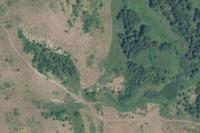

In [6]:
naip_item = gis.content.get("3f8d2d3828f24c00ae279db4af26d566")
naip_item

Now you've created an `Item` object, but to do any analysis you'll need to access a specific layer in that item.  This item only contains one layer, so you can just grab the first one by using the `.layers` property of the `Item` object.

In [7]:
lyr_naip = naip_item.layers[0]

## View the NAIP data.

You've created an `Item` and a `FeatureLayer` that represent the NAIP data.  Now you can view this data in a map.

#### 1.  Create a map view.

You can start viewing this data by creating a map view.  Center your map view on Mountain House, CA so you can check out the available data in the area.

In [8]:
map_view = gis.map("Mountain House, CA")
map_view

MapView(layout=Layout(height='400px', width='100%'))

#### 2.  Add the NAIP layer to the map.

Now that you've created a map view, you can add the NAIP imagery layer to it.

In [9]:
map_view.add_layer(lyr_naip)

Note that this didn't create a new map view, but added your layer to the one you created in the previous step.

## Export an Image

Now that we can see the area around Mountain House, we can export the current imagery.

#### 1.  Create a bounding box.

To export imagery, first you'll need to create a bounding box geometry.  We've set up a tuple that represents the extent of our area of interest.  You'll see this format fairly frequently as you work with bounding boxes and envelopes.  It usually contains four numbers that represent the xmin, ymin, xmax, and ymax.  We'll start by unpacking that.

In [14]:
# define extent by tuple
in_extent = (-13530675.228816083, 4545237.670432766, -13528866.137925146, 4547533.238415405) 

# unpack the extent tuple into individual variables
xmin, ymin, xmax, ymax = in_extent

Now you'll need to format those extent variables into a dictionary that can be turned into geometry.

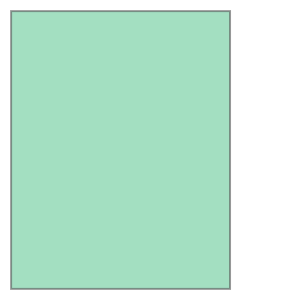

In [20]:
# create a dictionary for the envelope
extent_dict = {'xmin': xmin,
  'ymin': ymin,
  'xmax': xmax,
  'ymax': ymax,
  'spatialReference': {'wkid': 3857}}

# create an envelope geometry
envelope = arcgis.geometry.Envelope(extent_dict) 
envelope

This envelope will be useful for when we're exporting imagery later.  Unfortunately it won't render on a map because it represents an extent instead of an actual polygon.  If you want to see this on a map, you can create a `Polygon` object and add it to a DataFrame.  The map view can render that as a layer.  This is optional and won't affect any of our further processing.

In [40]:
# create a polygon from the envelope
p_dict = {'rings': [[
    [xmin, ymin],
    [xmin, ymax],
    [xmax, ymax],
    [xmax, ymin],
    [xmin, ymin]
]], 'spatialReference': {'wkid': 3857}}

poly = arcgis.geometry.Polygon(p_dict)

In [52]:
# create a DataFrame and add to map
df = pd.DataFrame([{"SHAPE": poly}])
df.spatial.set_geometry("SHAPE")
map_view.add_layer(df)

#### 2.  Figure out the size of the image to export.

Because we've created this envelope in a projected coordinate system, we can use some basic math to determine the pixel size of our output based on the coordinates of our bounding box.  We'll determine the width by subtracting the minimum X value from the maximum, then multiplying that by the meters per unit in our spatial reference.  Then we'll divide all of that by the NAIP resolution, giving us the pixels per meter.

$$
w = \left\lfloor \frac{(x_{\text{max}} - x_{\text{min}}) \cdot \text{Envelope Meters per Unit}}{\text{NAIP Resolution}} \right\rfloor
$$

You can generate the height by performing the same equation but using the Y values instead of the X values.  In our case, the meters per unit is 1 as we're using Web Mercator.  The NAIP resolution also happens to be 1 in this case because we're using 1m resolution imagery.

In [53]:
# NAIP Resolution
naip_res = 1 

# Web Mercator meters per unit
metersPerUnit = 1

# calculate the width and height of our output in pixels
w = int((xmax - xmin) * metersPerUnit / naip_res)
h = int((ymax - ymin) * metersPerUnit / naip_res)

[w,h]

[1809, 2295]

#### 3.  Determine the date of the imagery to export.

The final thing that we'll need to determine before exporting our imagery is which date to export.  In a web browser, you'd be able to see the available dates by clicking on a point in the map.  A popup comes up and tells you which dates of imagery are available.  In this case, you'll do the same thing Pythonically.  You'll query the imagery layer in the same way you would a feature layer.

In [57]:
df_naip = lyr_naip.query(
    where = "AcquisitionDate IS NOT NULL",
    geometry_filter = arcgis.geometry.filters.intersects(
        geometry=envelope, 
        sr=envelope.spatial_reference),
    as_df=True,
    )
df_naip

OBJECTID                                   Name  MinPS  MaxPS  Category  \
0    142391             m_3712112_se_10_1_20120520      0   19.1         1   
1    349093             m_3712112_se_10_1_20140606      0   19.1         1   
2    591392             m_3712112_se_10_h_20160621      0   19.1         1   
3    822579  m_3712112_se_10_060_20180725_20190209      0   19.1         1   
4   1110924           m_3712112_se_10_060_20200527      0   19.1         1   
5   1255435           m_3712112_se_10_060_20220518      0   19.1         1   

  State  Year  AcquisitionDate   AREA  PERIMETER  ...         ArcKey Band  \
0    CA  2012    1337472000000  0.004       0.25  ...  3745001213000  M4B   
1    CA  2014    1402012800000  0.004       0.25  ...  3745001213000  M4B   
2    CA  2016    1466467200000  0.004       0.25  ...  3745001213000  M4B   
3    CA  2018    1532476800000  0.004       0.25  ...           None  M4B   
4    CA  2020    1590537600000  0.004       0.25  ...           None  M4B   
5    CA  2022    1652832000000  0.004       0.25  ...                 M4B   

    USGSID Qdrnt UTM SrcImgDate   VerDate  \
0  3712112    SE  10   20120520  20120730   
1  3712112    SE  10   20140606  20141007   
2  3712112    SE  10   20160621  20161004   
3  3712112  None  10   20180725  20190209   
4  3712112  None  10   20200527  20200828   
5  3712112  None  10   20220518  20220908   

                                    FileName  Res  \
0    m_3712112_se_10_1_20120520_20120730.tif  1.0   
1    m_3712112_se_10_1_20140606_20141007.tif  1.0   
2    m_3712112_se_10_h_20160621_20161004.tif  0.6   
3  m_3712112_se_10_060_20180725_20190209.tif  0.6   
4  m_3712112_se_10_060_20200527_20200828.tif  0.6   
5  m_3712112_se_10_060_20220518_20220908.tif  0.6   

                                               SHAPE  
0  {"rings": [[[-13524930.5287, 4543660.201300003...  
1  {"rings": [[[-13524940.0404, 4544092.303599998...  
2  {"rings": [[[-13525143.7612, 4543876.111699998...  
3  {"rings": [[[-13525137.4954, 4544268.160400003...  
4  {"rings": [[[-13525082.3992, 4543920.798100002...  
5  {"rings": [[[-13525082.3992, 4543920.798100002...  

[6 rows x 34 columns]

Note that there is a "Year" column that shows the year as an integer.  There's also an "AcquisitionDate" column which shows the date of the imagery capture as an epoch timestamp.

In [58]:
df_naip[['Year','AcquisitionDate']]

Year  AcquisitionDate
0  2012    1337472000000
1  2014    1402012800000
2  2016    1466467200000
3  2018    1532476800000
4  2020    1590537600000
5  2022    1652832000000

The timestamp is very handy, because that's what we'll need to provide to export an image from the imagery layer.  Save the first acquisition date as a variable for later use.  We'll export the 2012 data first.

In [79]:
filter_date = df_naip['AcquisitionDate'][0]
filter_date

1337472000000

#### 4.  Export an image from the imagery layer.

We'll start by exporting the 2012 data as a jpeg file to visually inspect the change over time.  This is a lightweight way of allowing us to view this data without having to create large tiff files.  Also, jpeg files can be rendered within the browser in a Jupyter Notebook, so it makes for easy visual data review.

We'll use a method on the NAIP layer called `export_image()` to export the image.  Review the documentation for the method first.

In [77]:
lyr_naip.export_image?

You won't need to populate all those parameters, but you will need to specify the bounding box, spatial references, export format, and the band that you want to export.

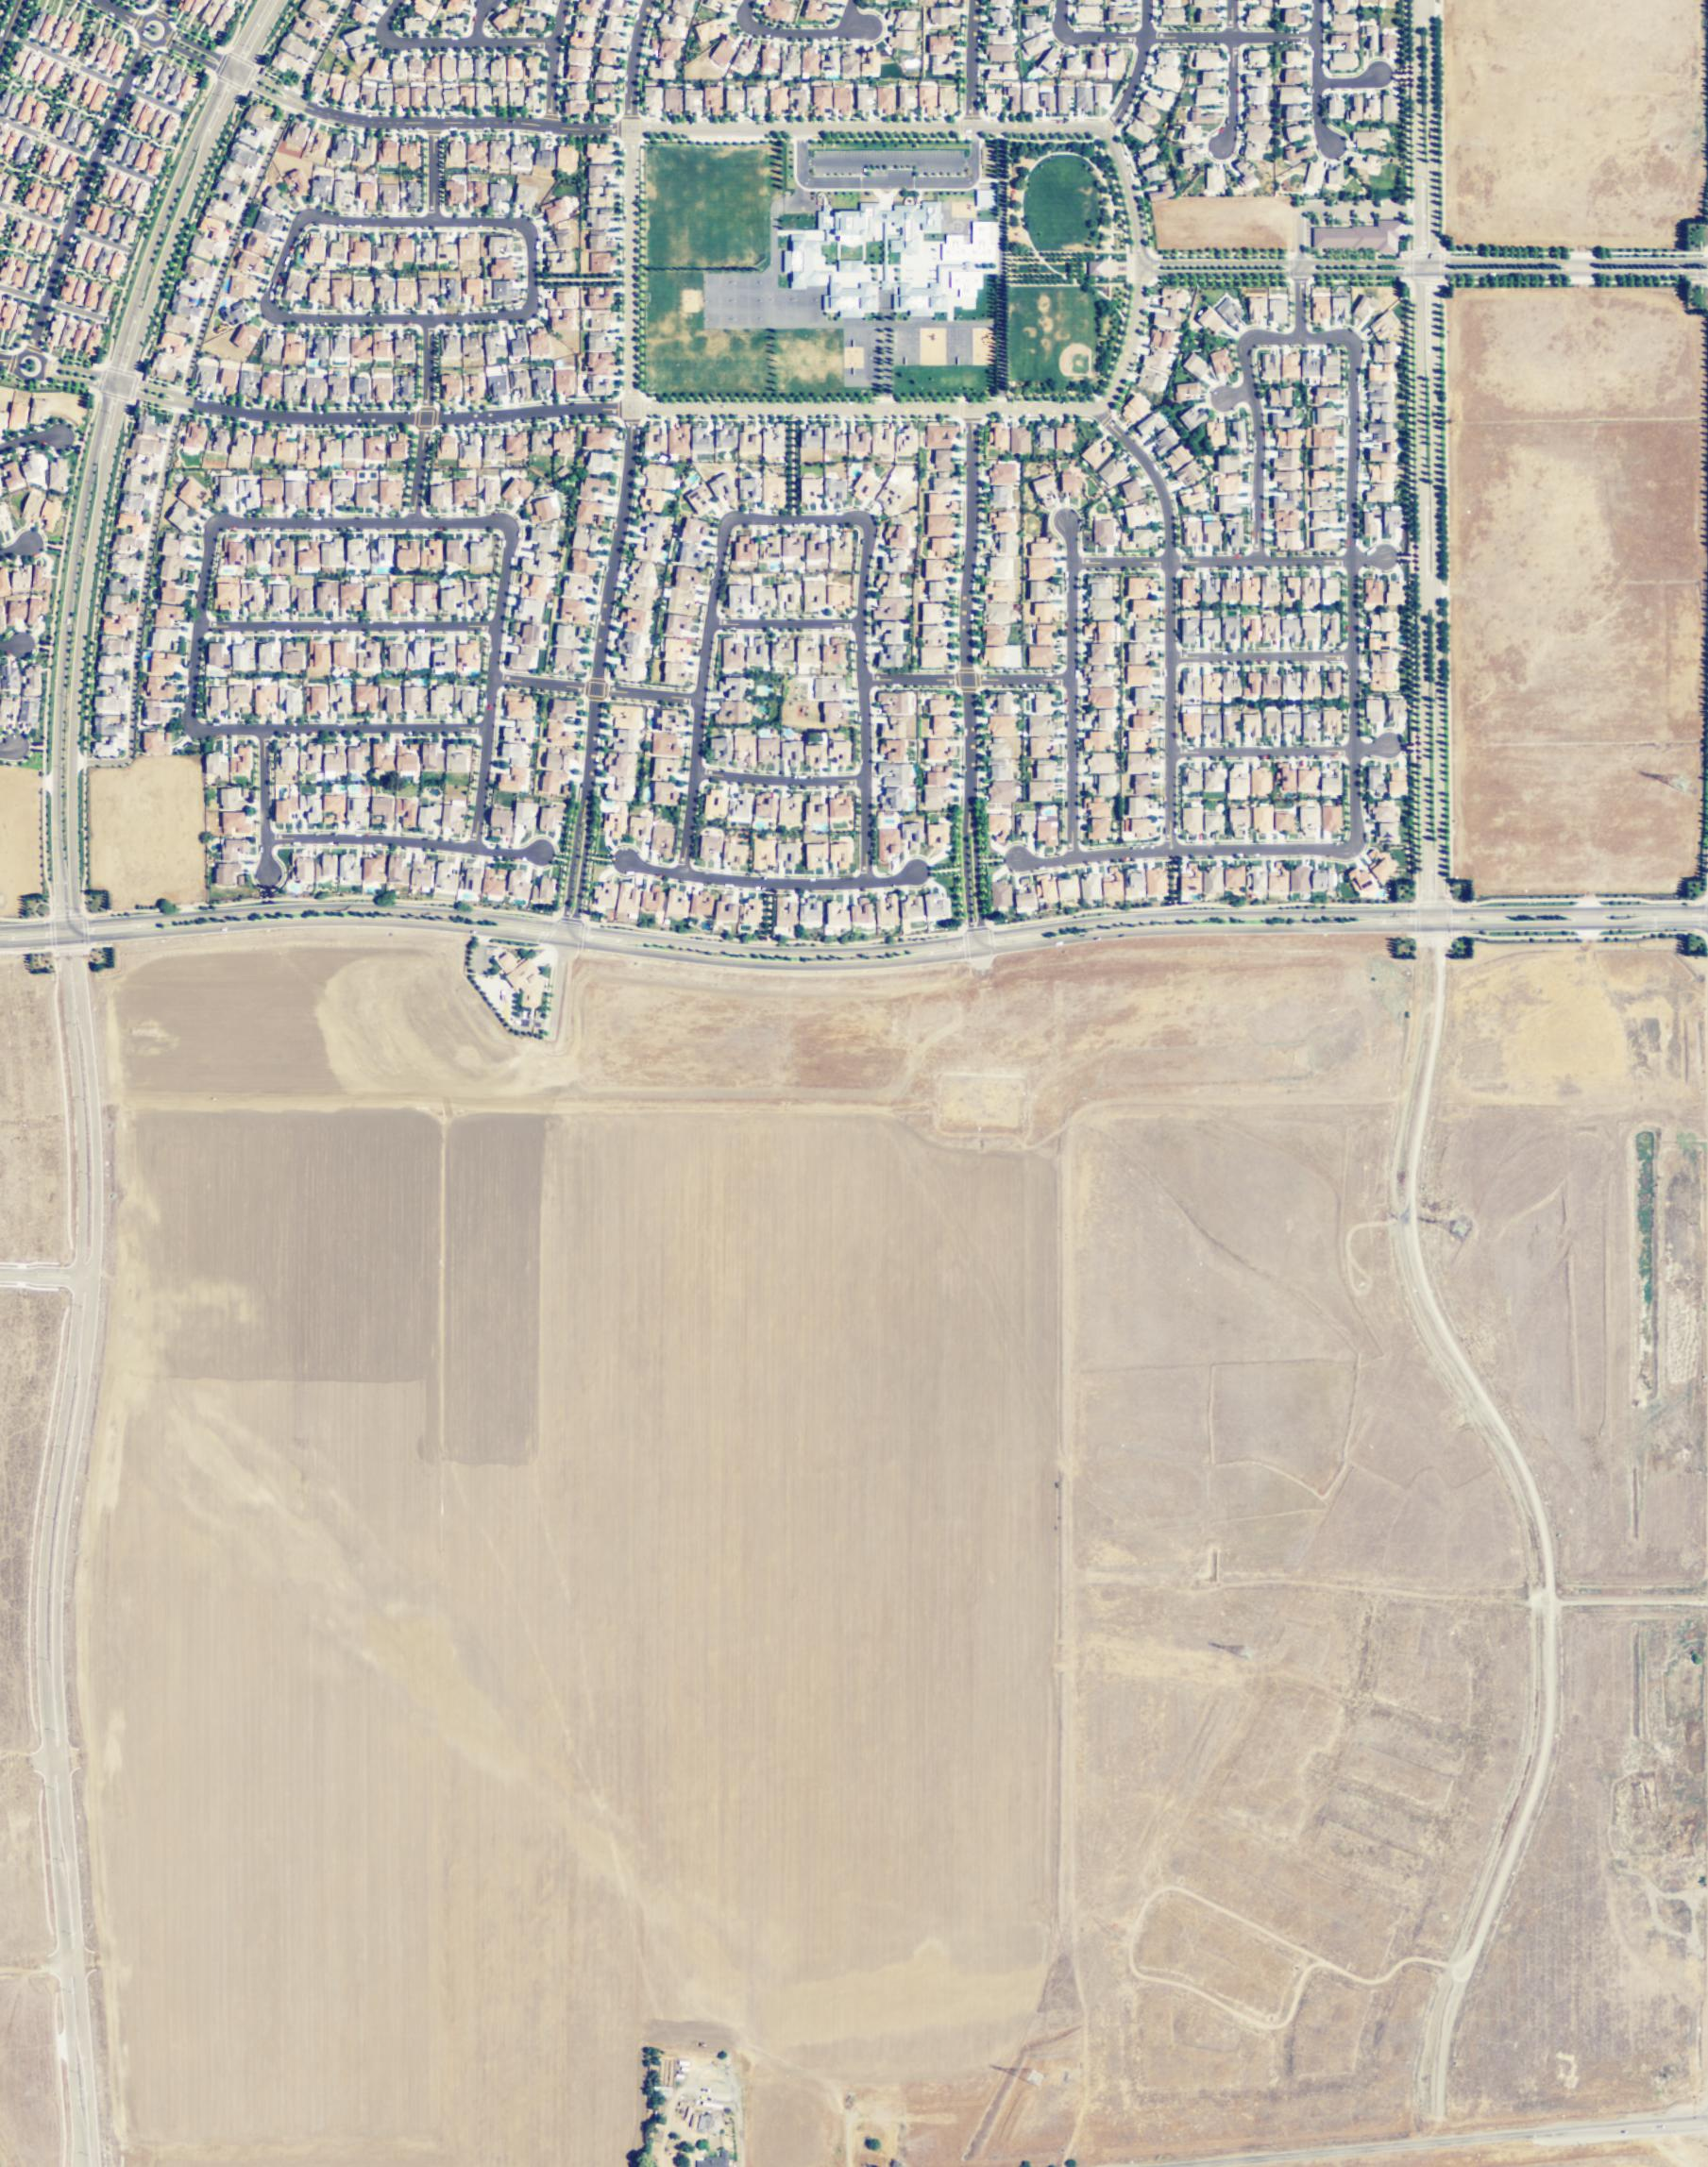

In [80]:
mountain_house_2012 = lyr_naip.export_image(
        bbox = envelope, # bounding box generated earlier
        bbox_sr = 3857, # bounding box spatial reference (web mercator)
        image_sr = 3857, # bounding box spatial reference (web mercator)
        time = filter_date, # timestamp representing 2012 acquisition date
        rendering_rule = {'rasterFunction': "NaturalColor"}, # which bands to include
        f = "image", # specify image output
        export_format='jpeg', # output image format
        size = [w,h], # width and height that we generated earlier
        save_folder = r".", # output folder - this is the one that the script is in
        save_file = rf"mountain_house_2012.jpg", # file name
        )

Image(mountain_house_2012)

Note that there is a lot less development in the 2012 imagery.

## Export Multiple Images

Seeing the difference in development between 2012 and the current imagery in the map view is fairly striking.  That's a lot of development that occurred in a 10 year period.  Now let's look at all the years in between.

#### 1.  Create a list of years and dates.

To make the files you're creating more readable, it would help to put the year in the file name.  You can use the DataFrame you generated earlier to create a list of dictionaries

In [83]:
years_and_dates = df_naip[['Year','AcquisitionDate']].to_dict('records')
years_and_dates[0]

{'Year': 2012, 'AcquisitionDate': 1337472000000}

#### 2.  Iterate through the list of dates and export images.

2012


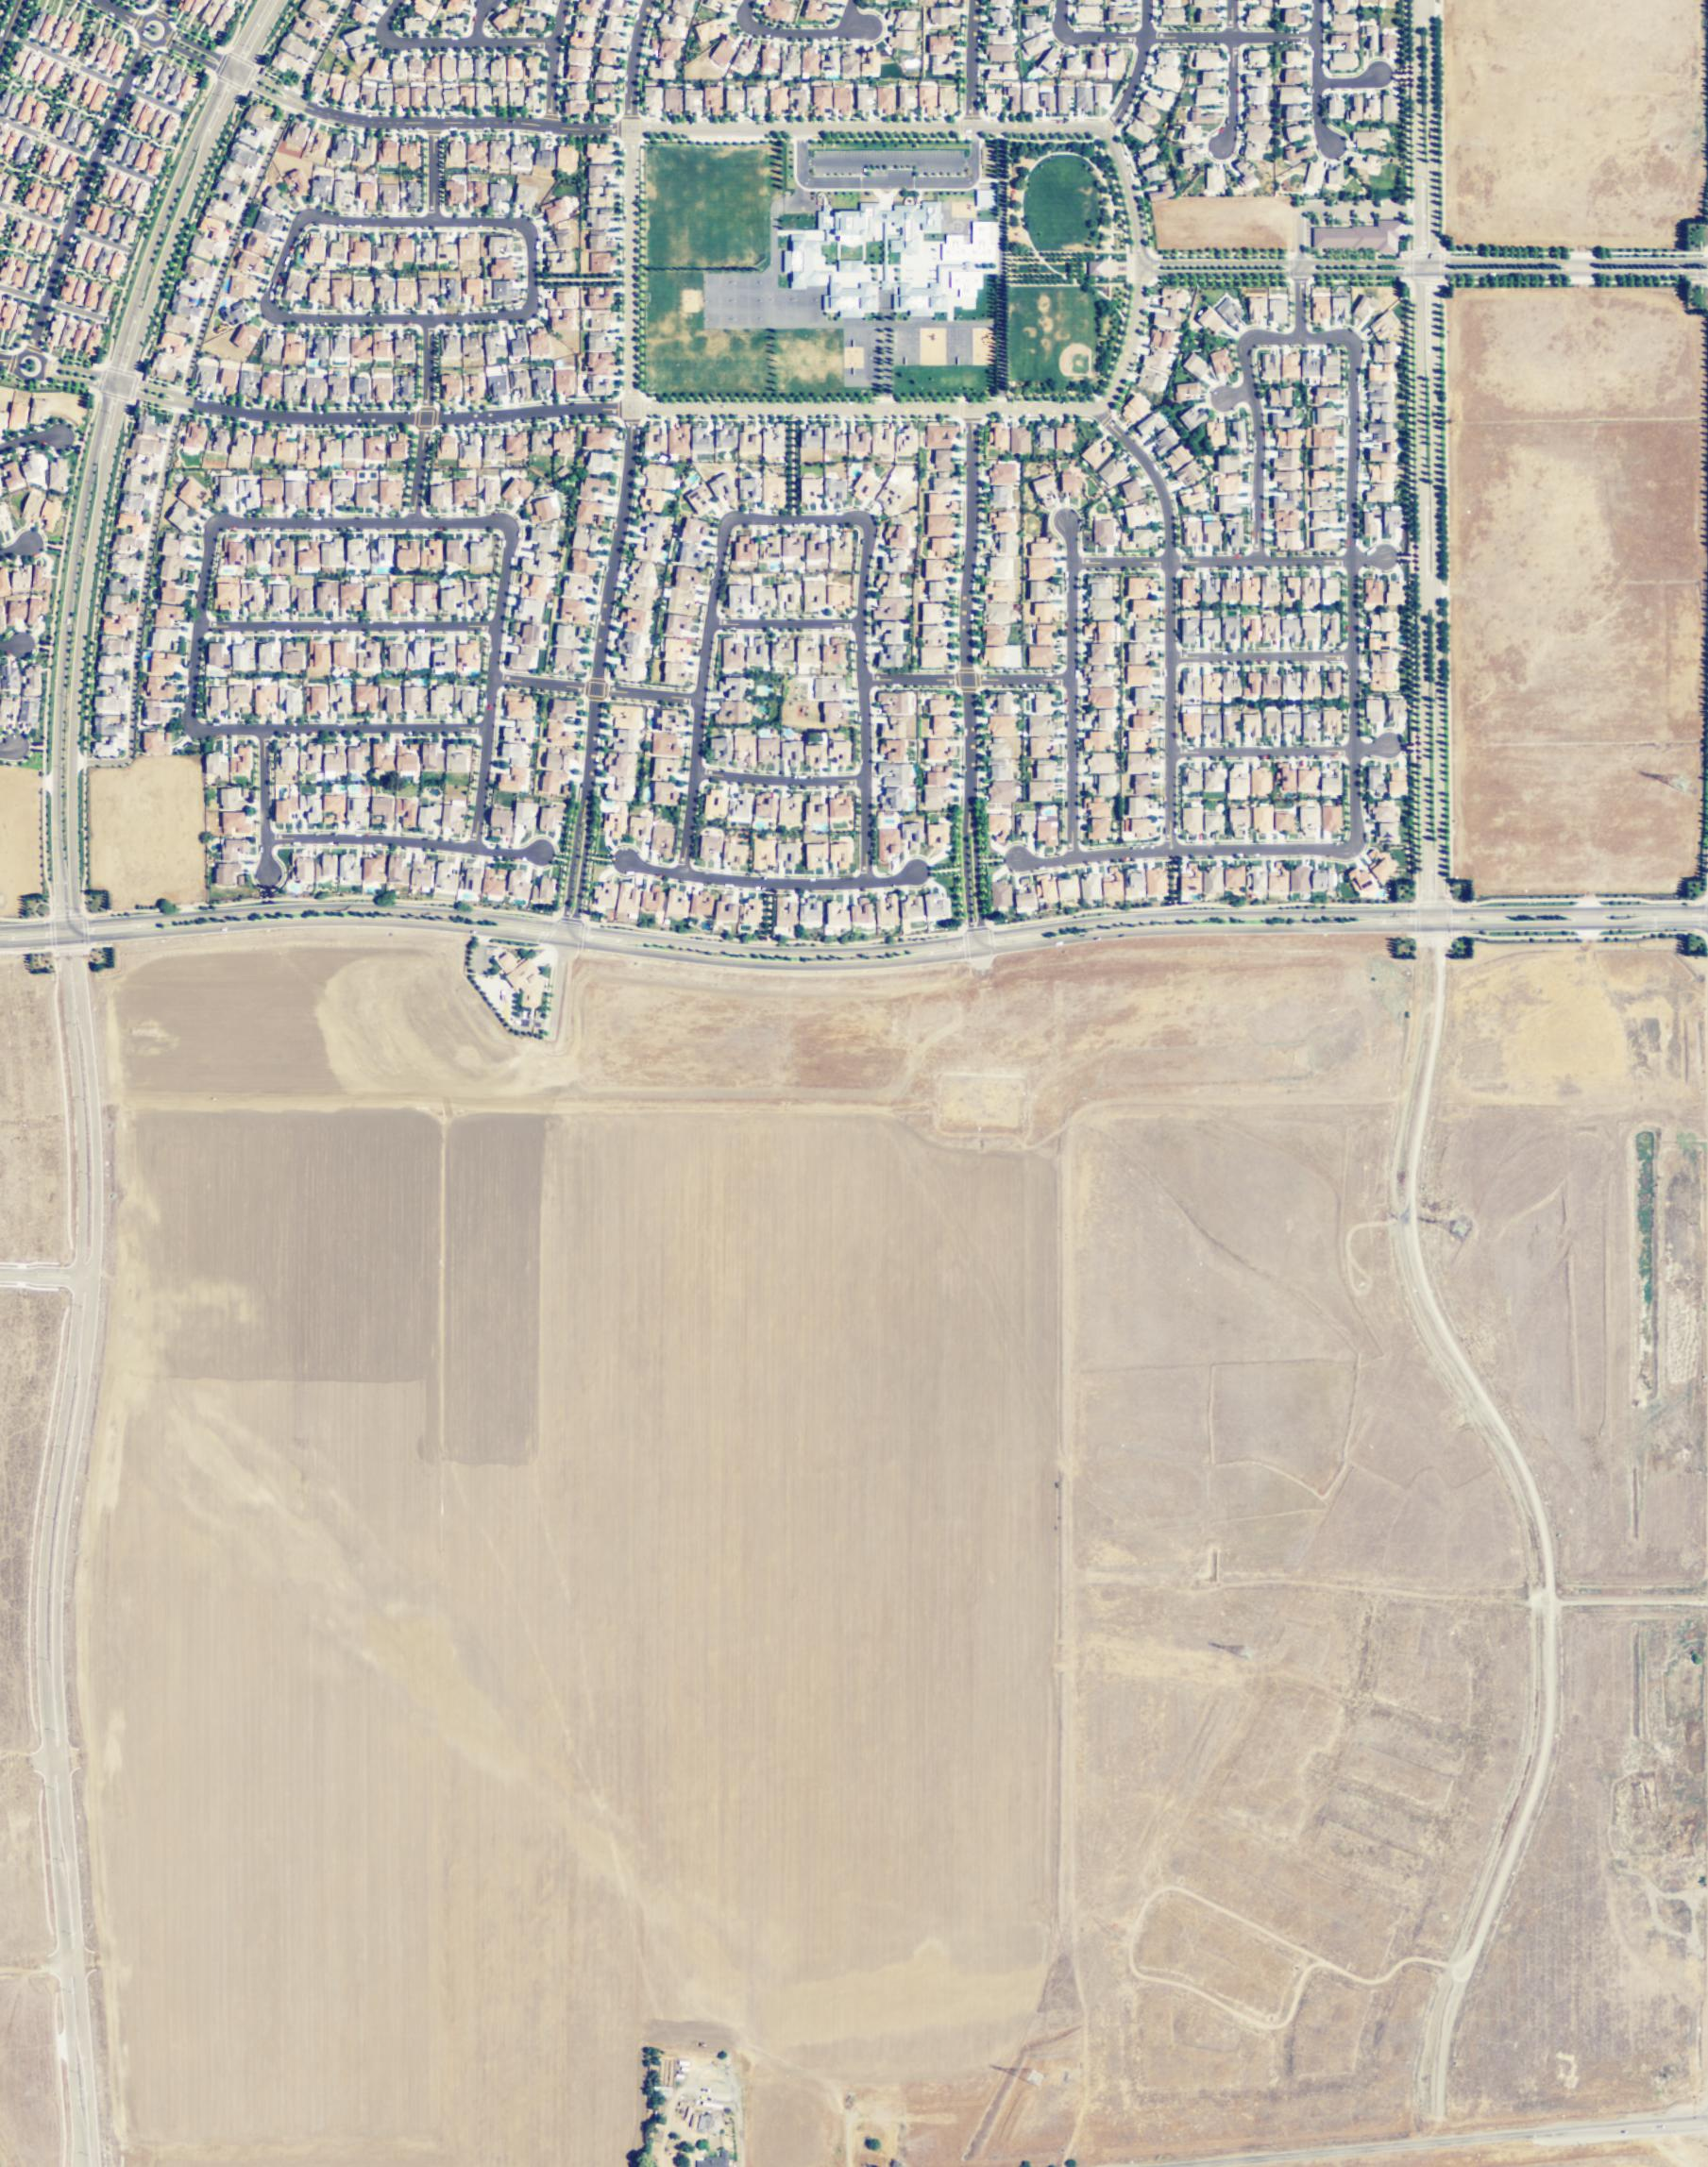

2014


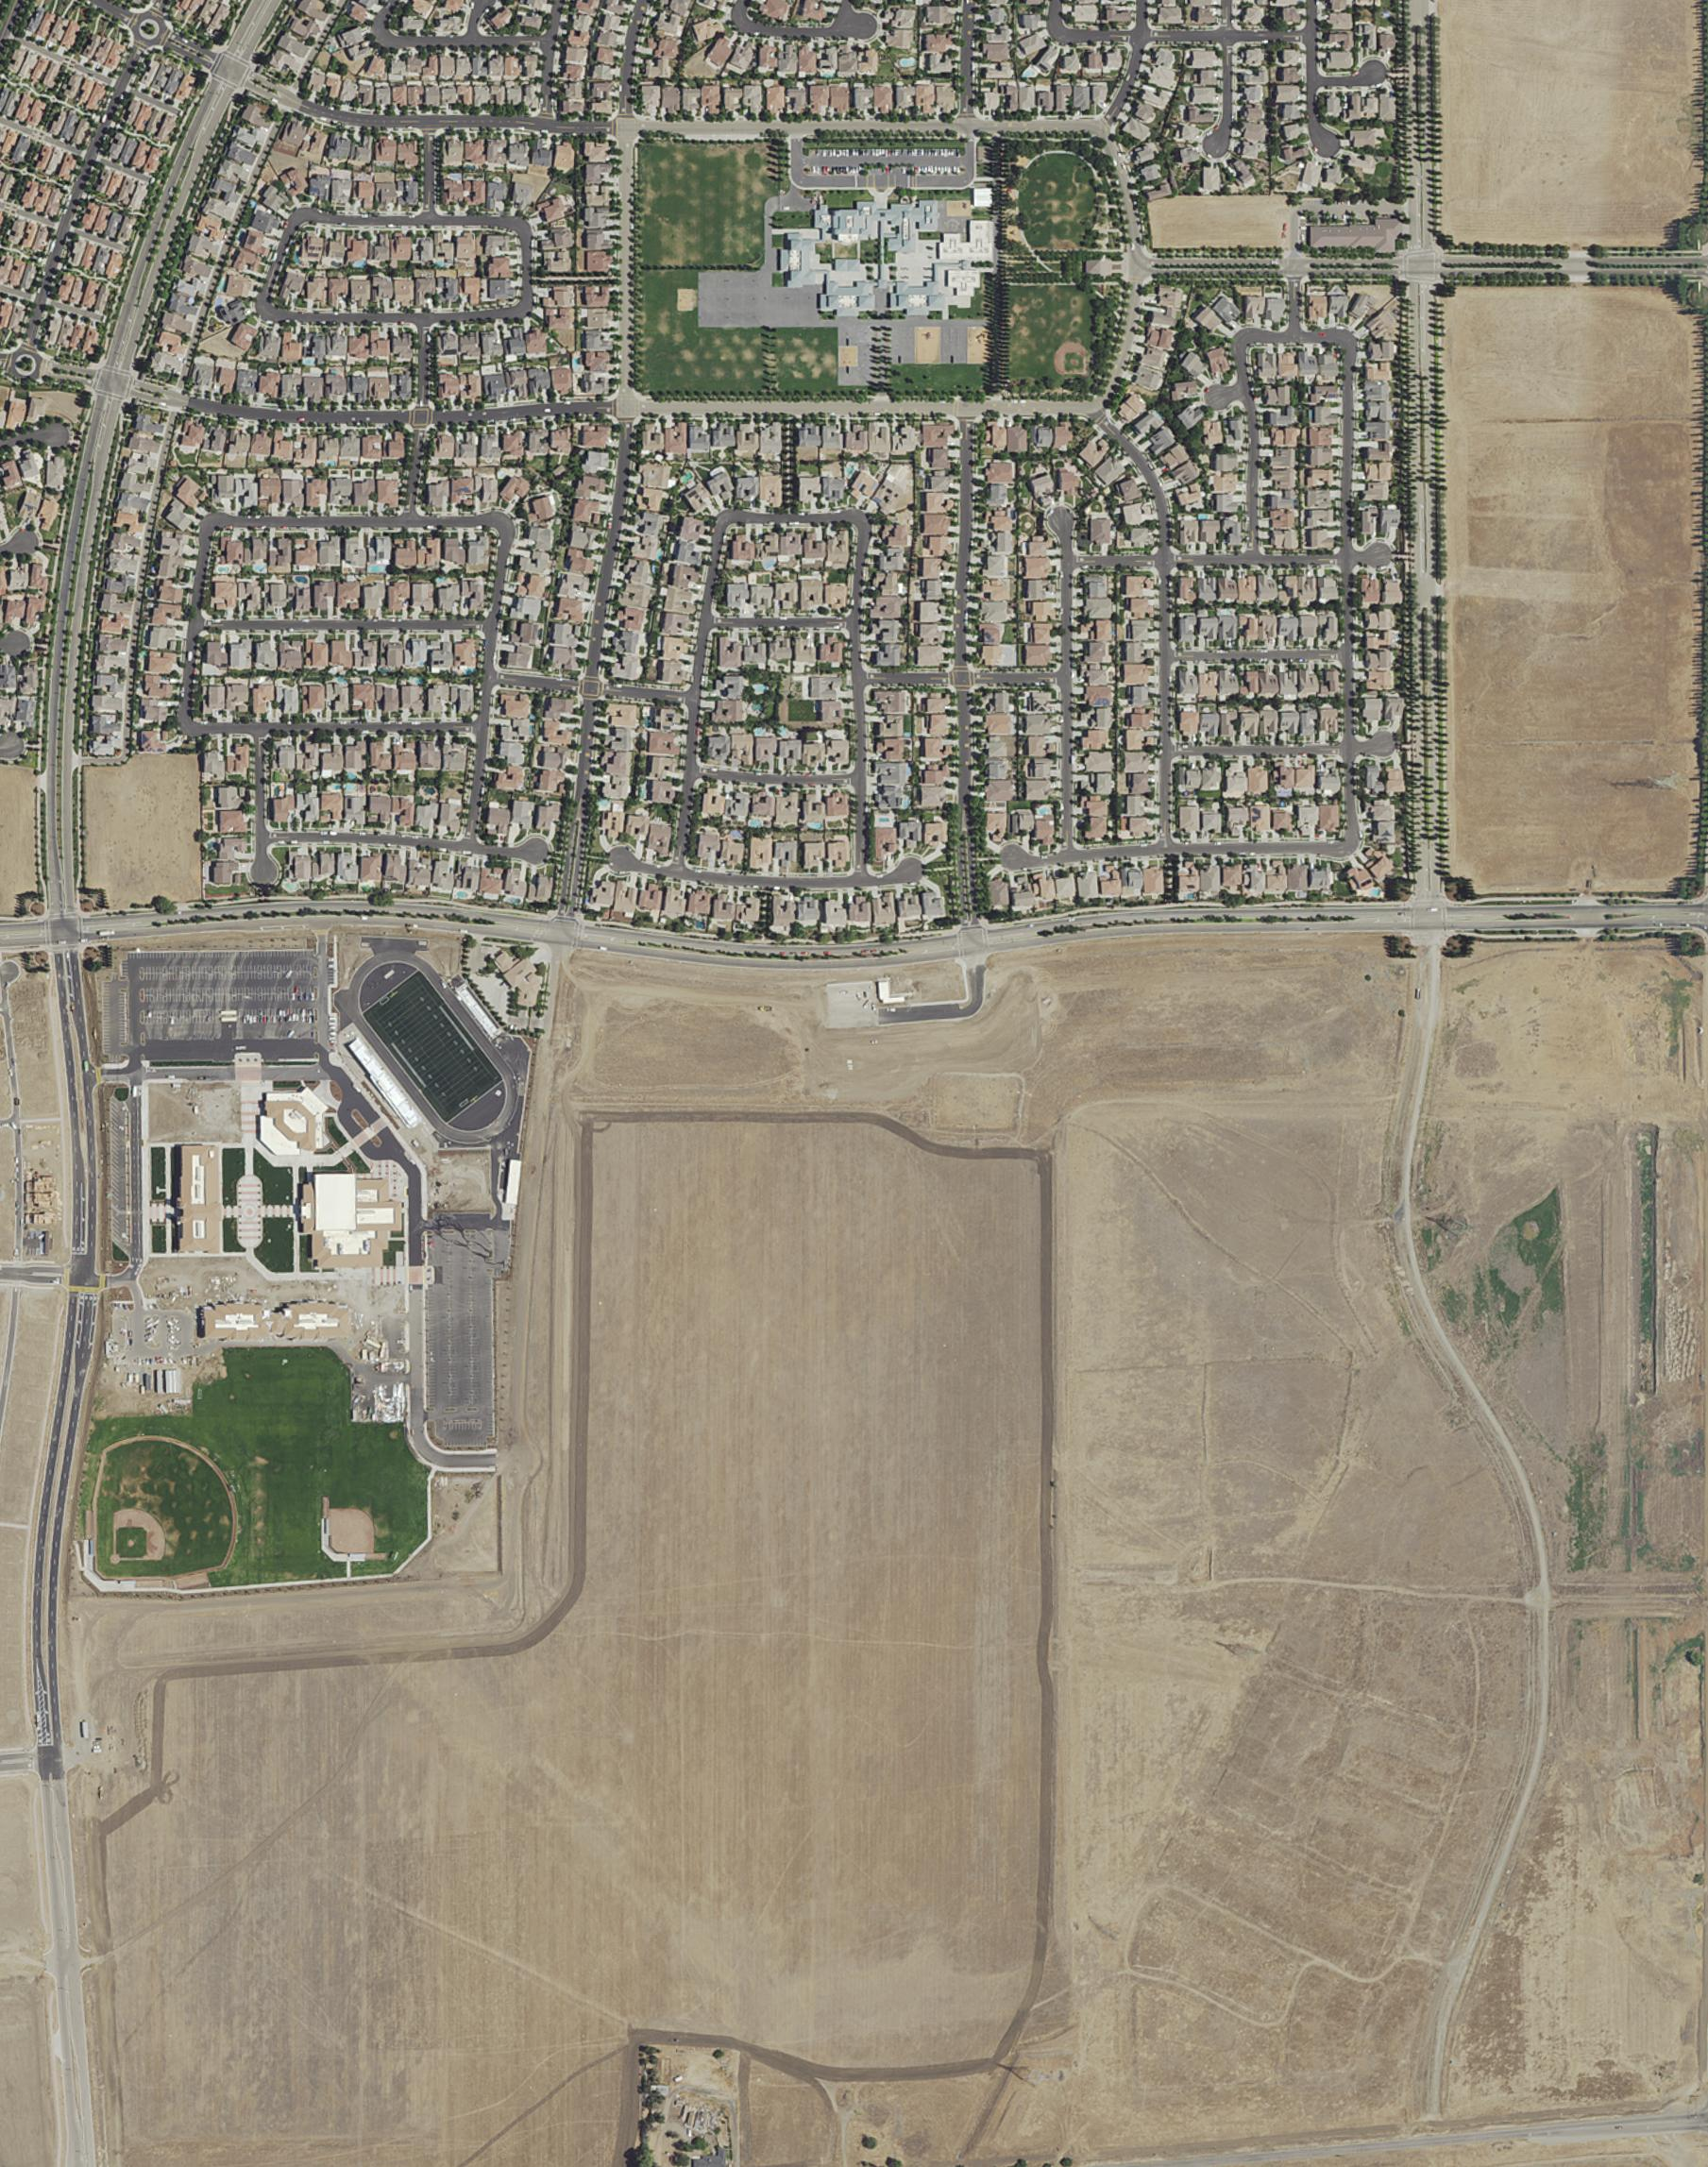

2016


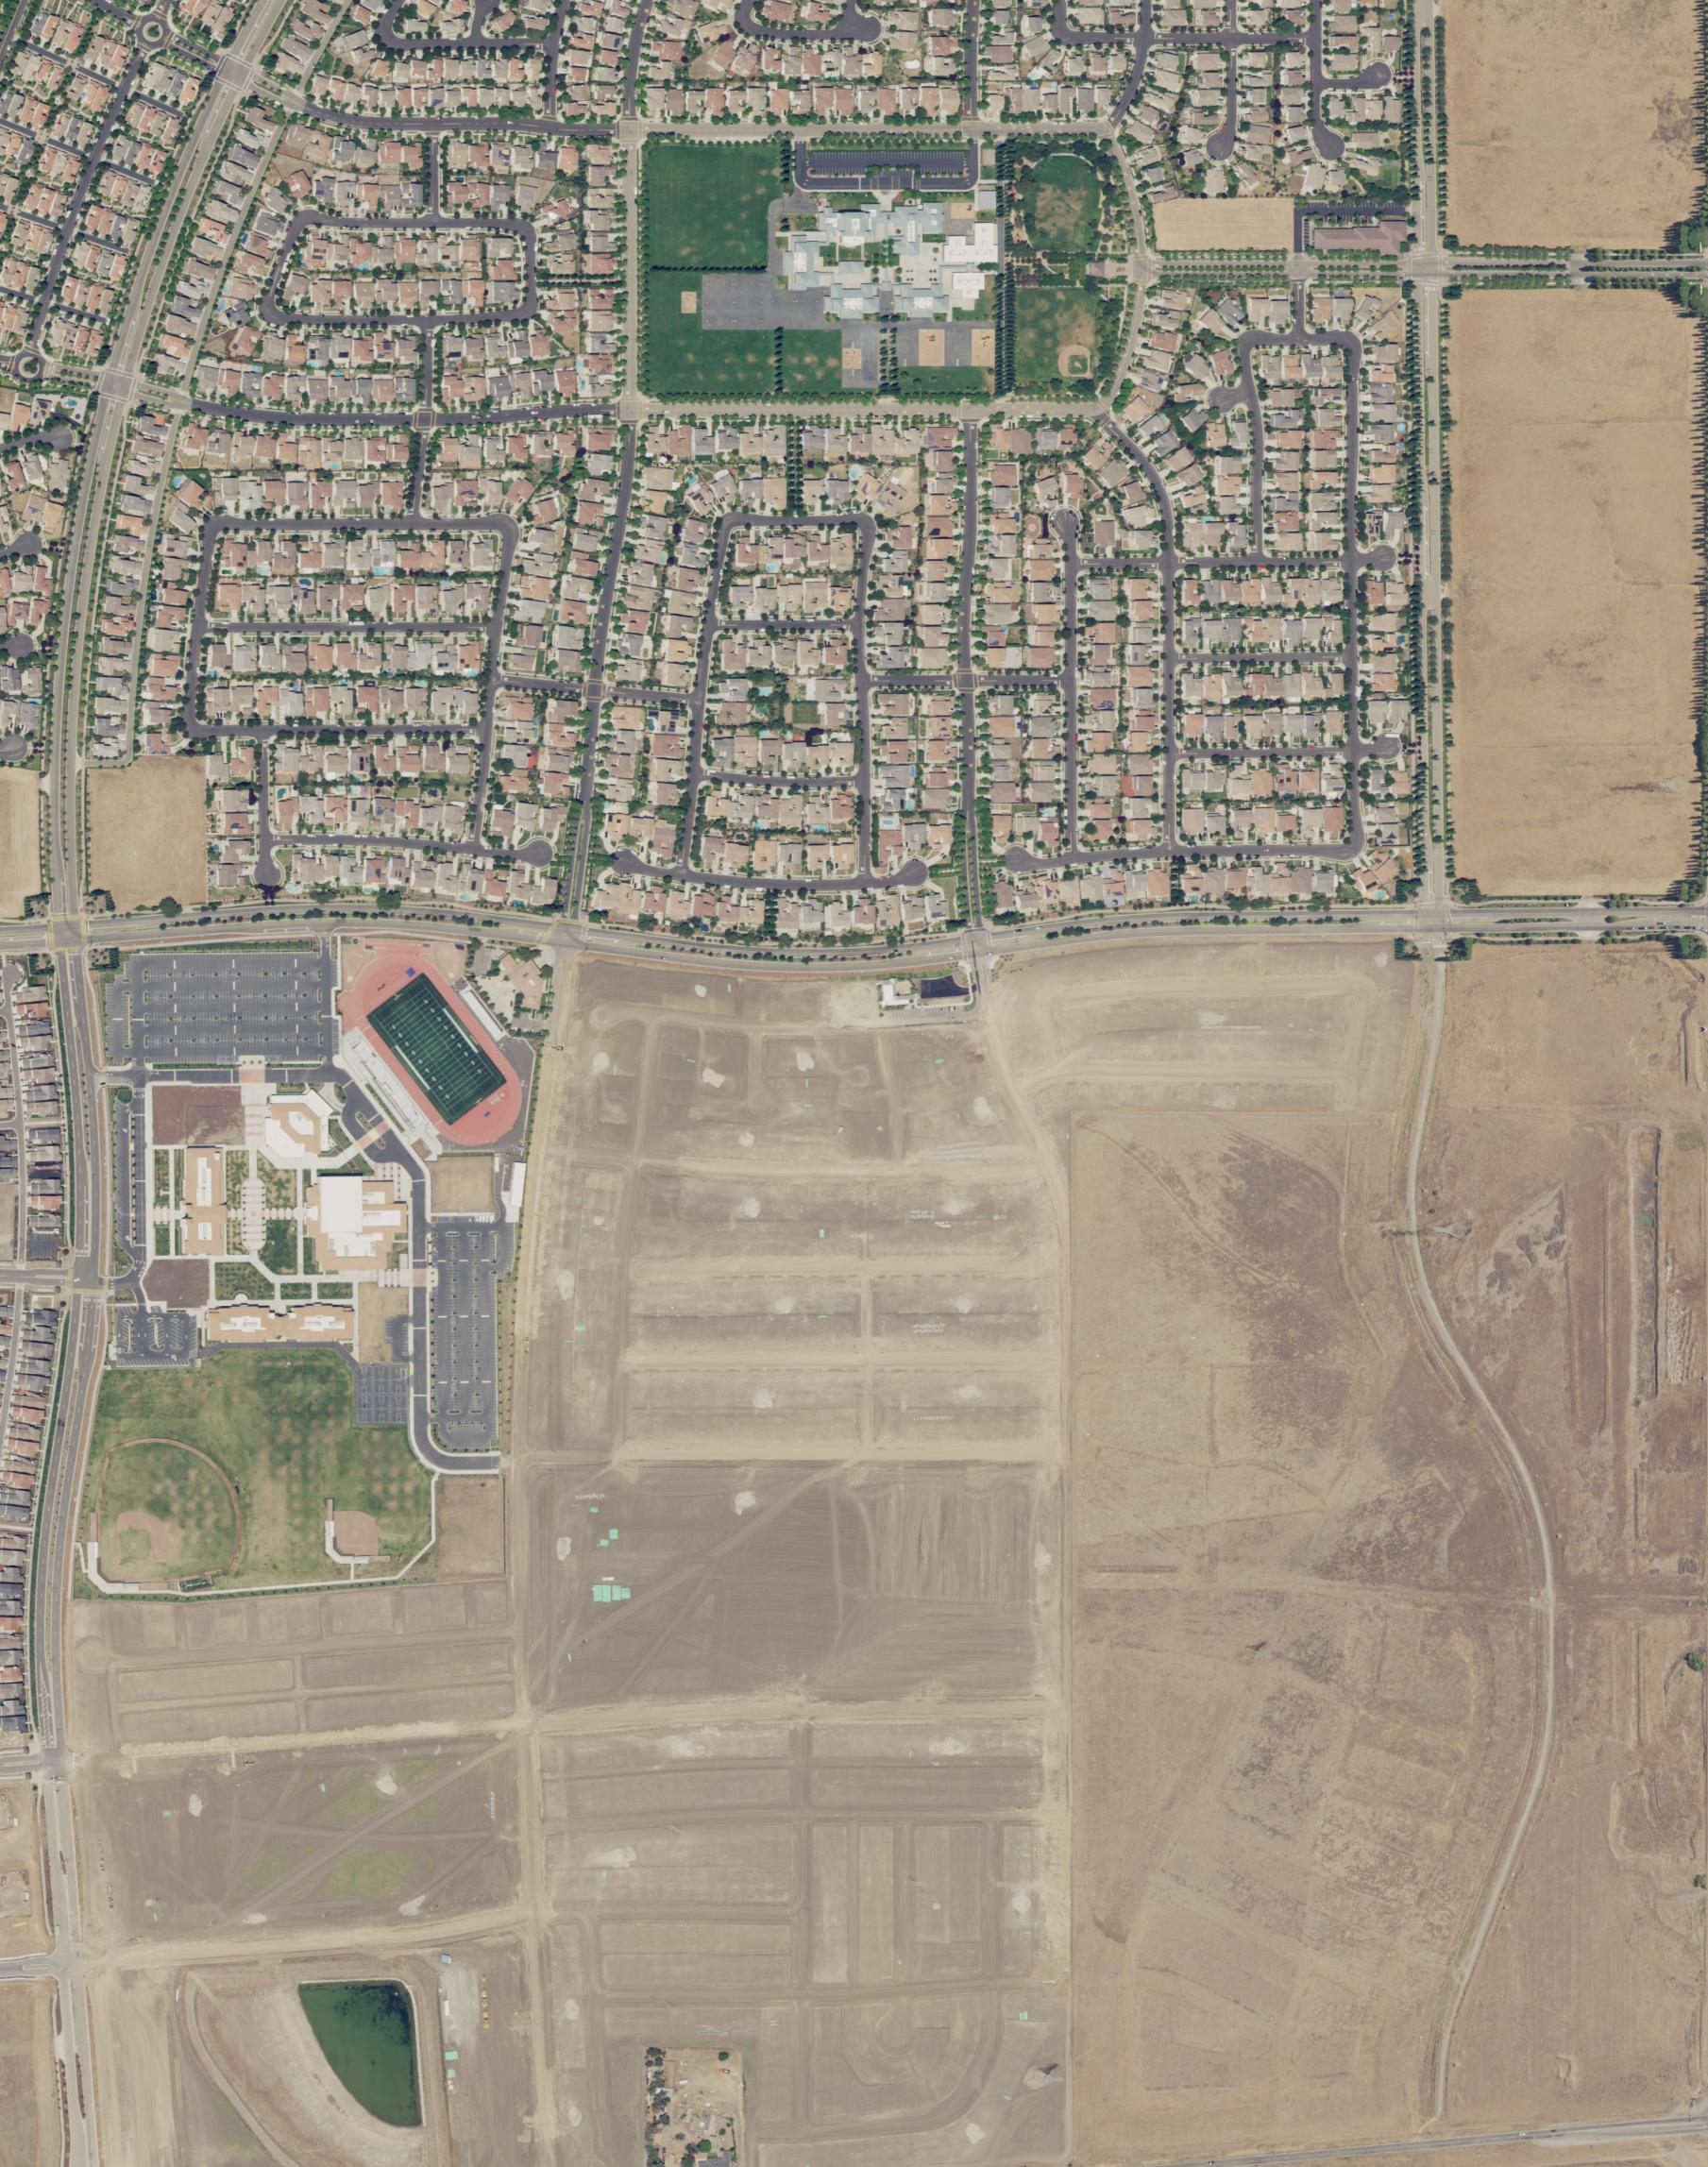

2018


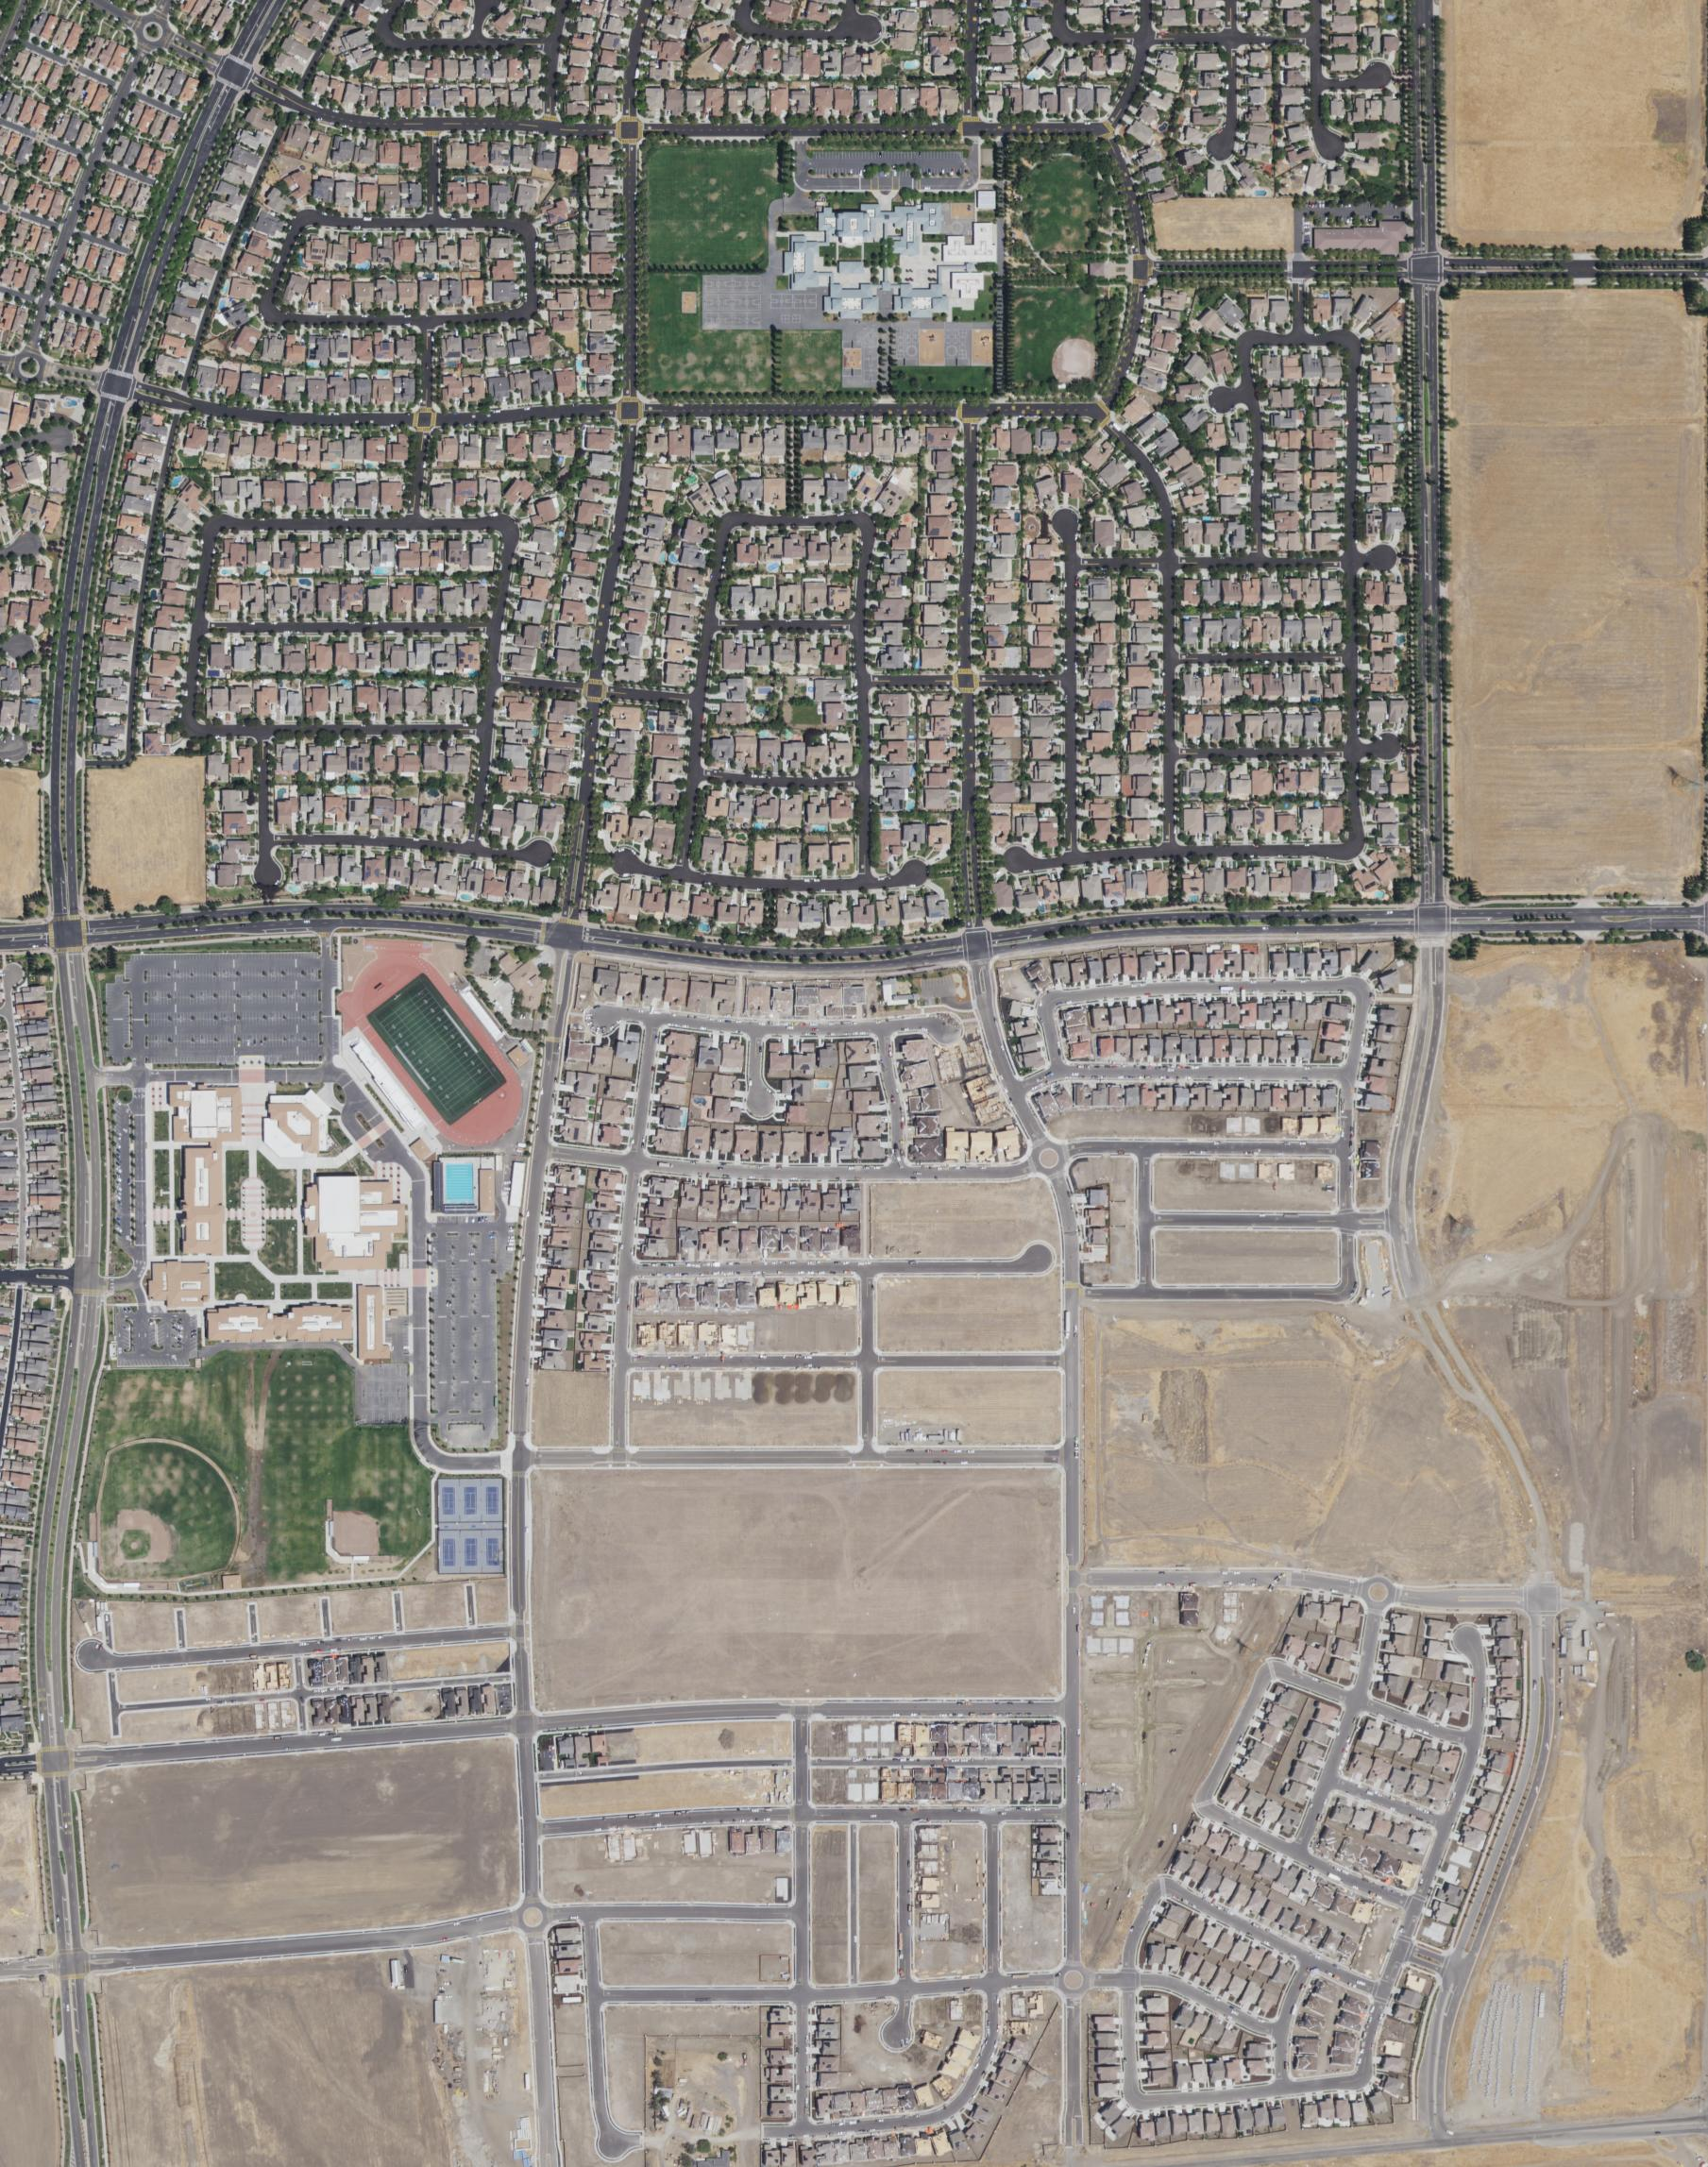

2020


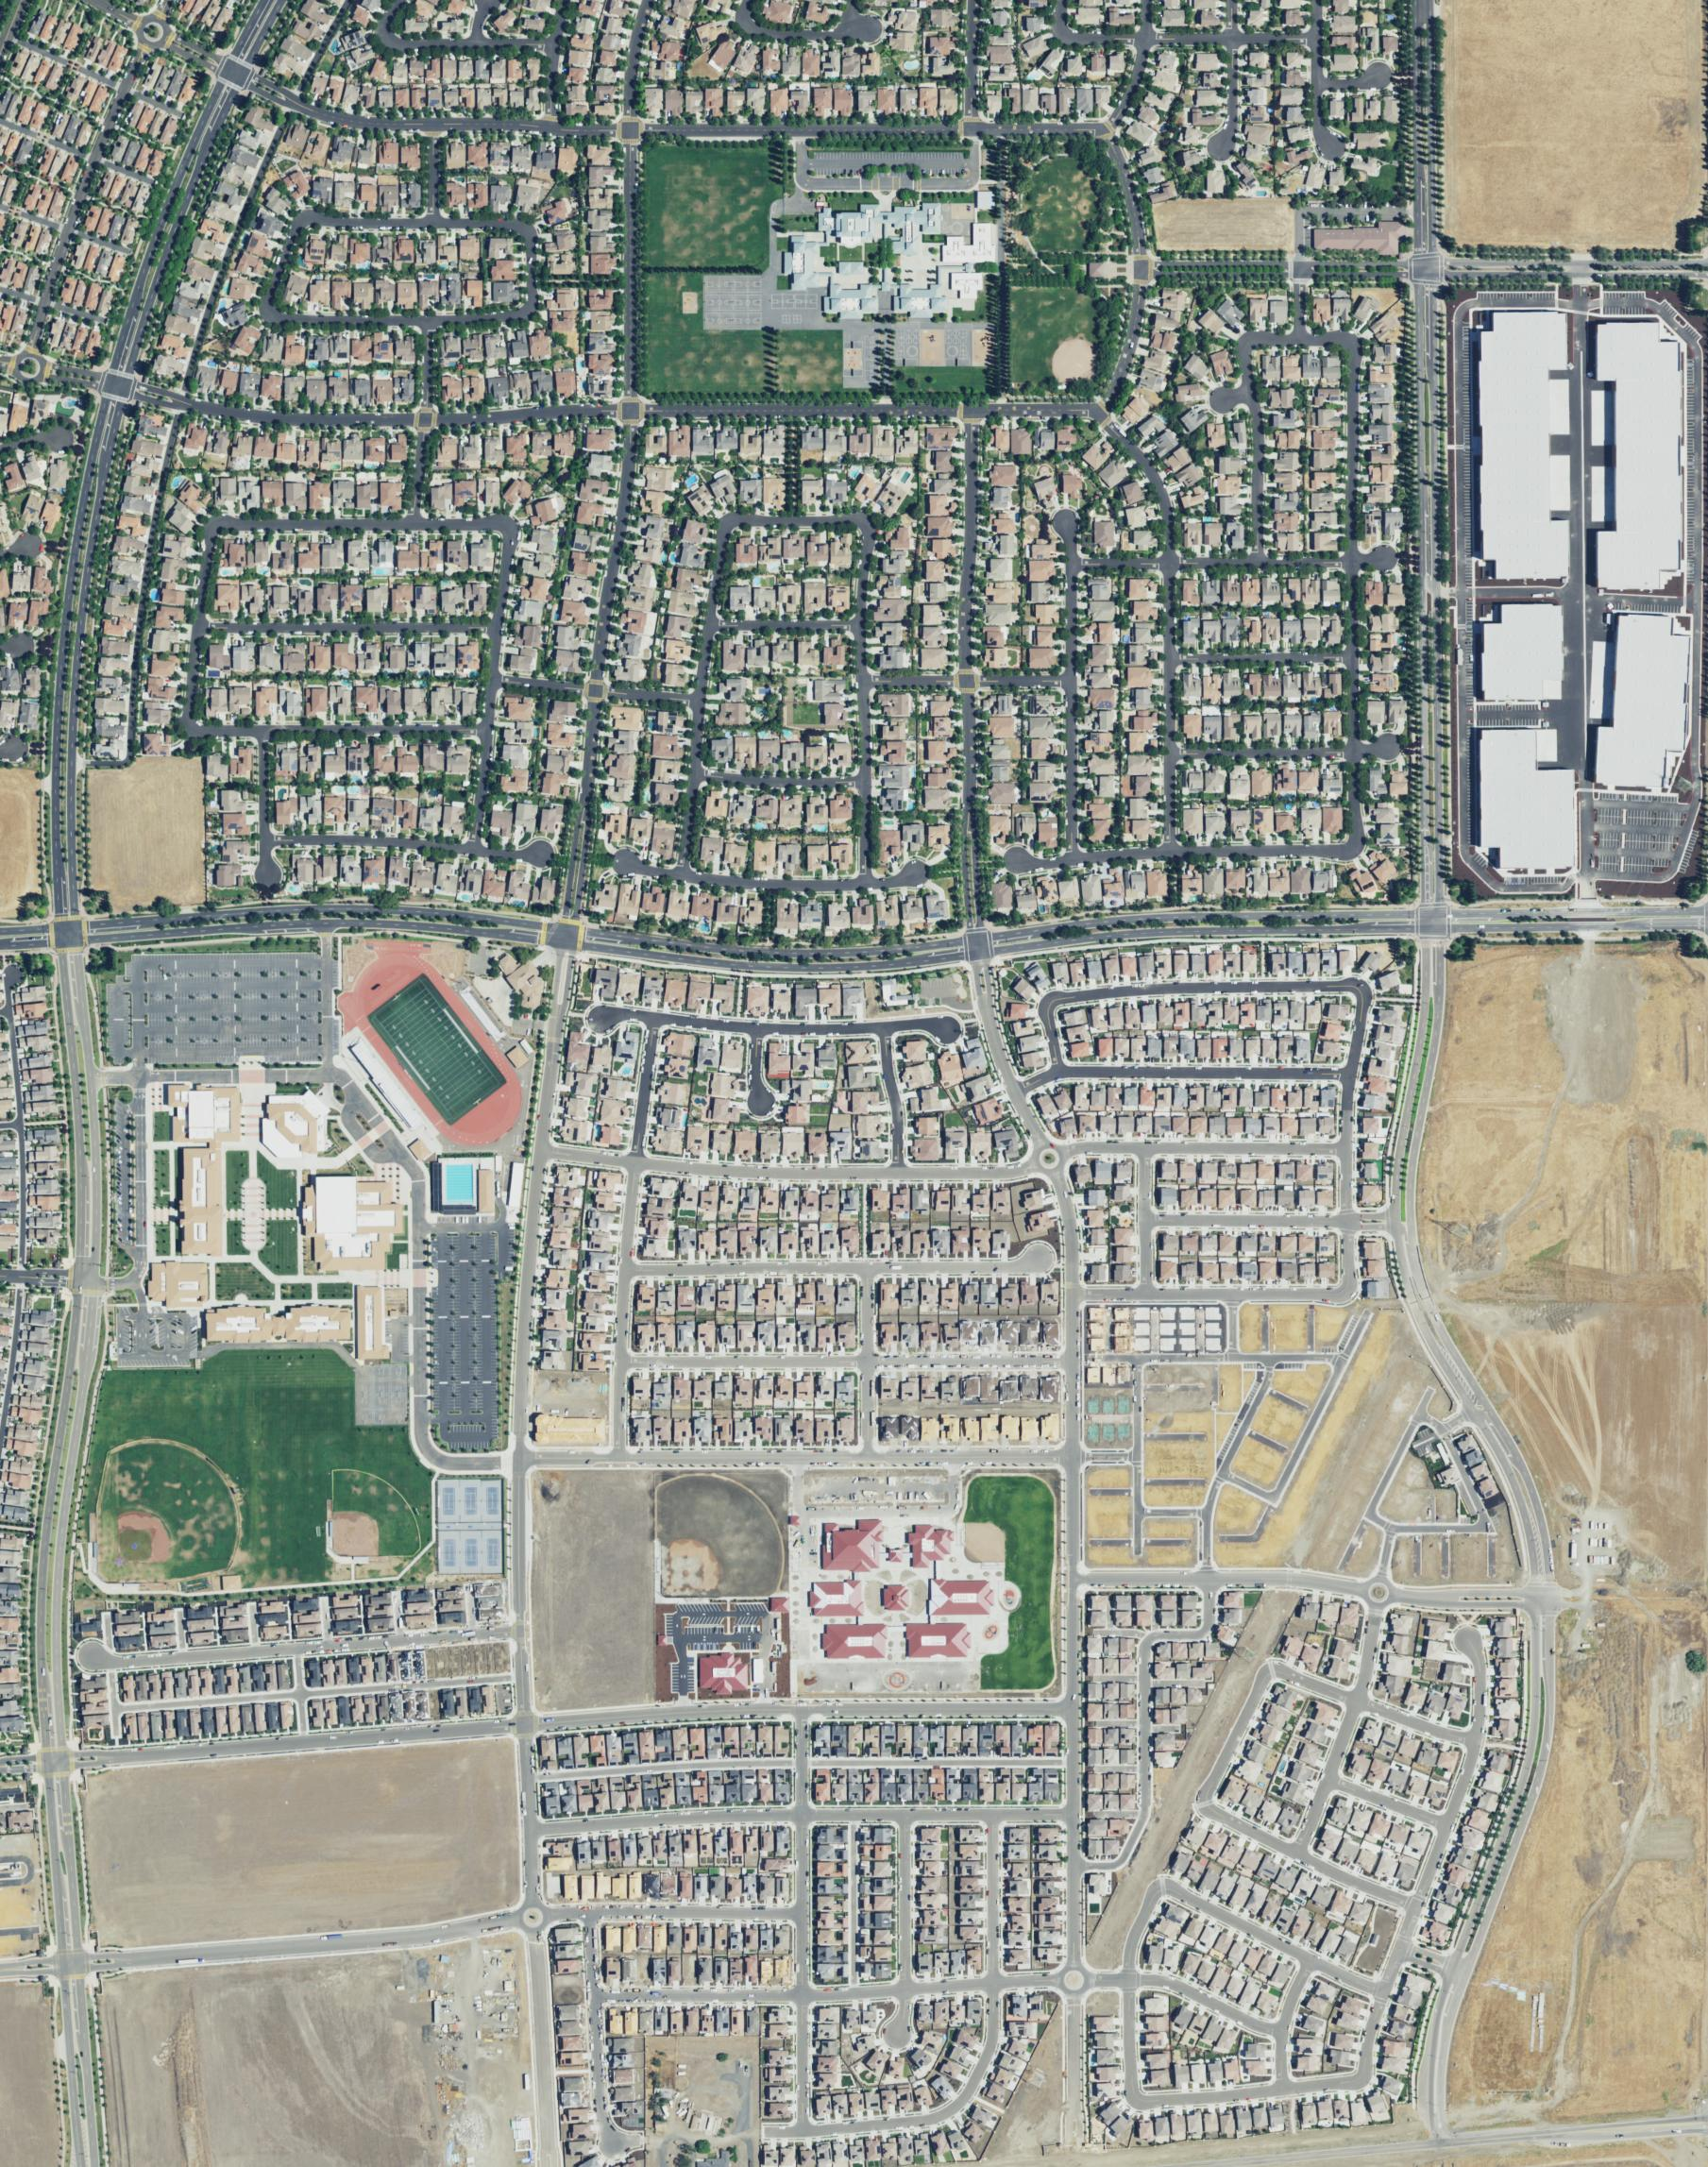

2022


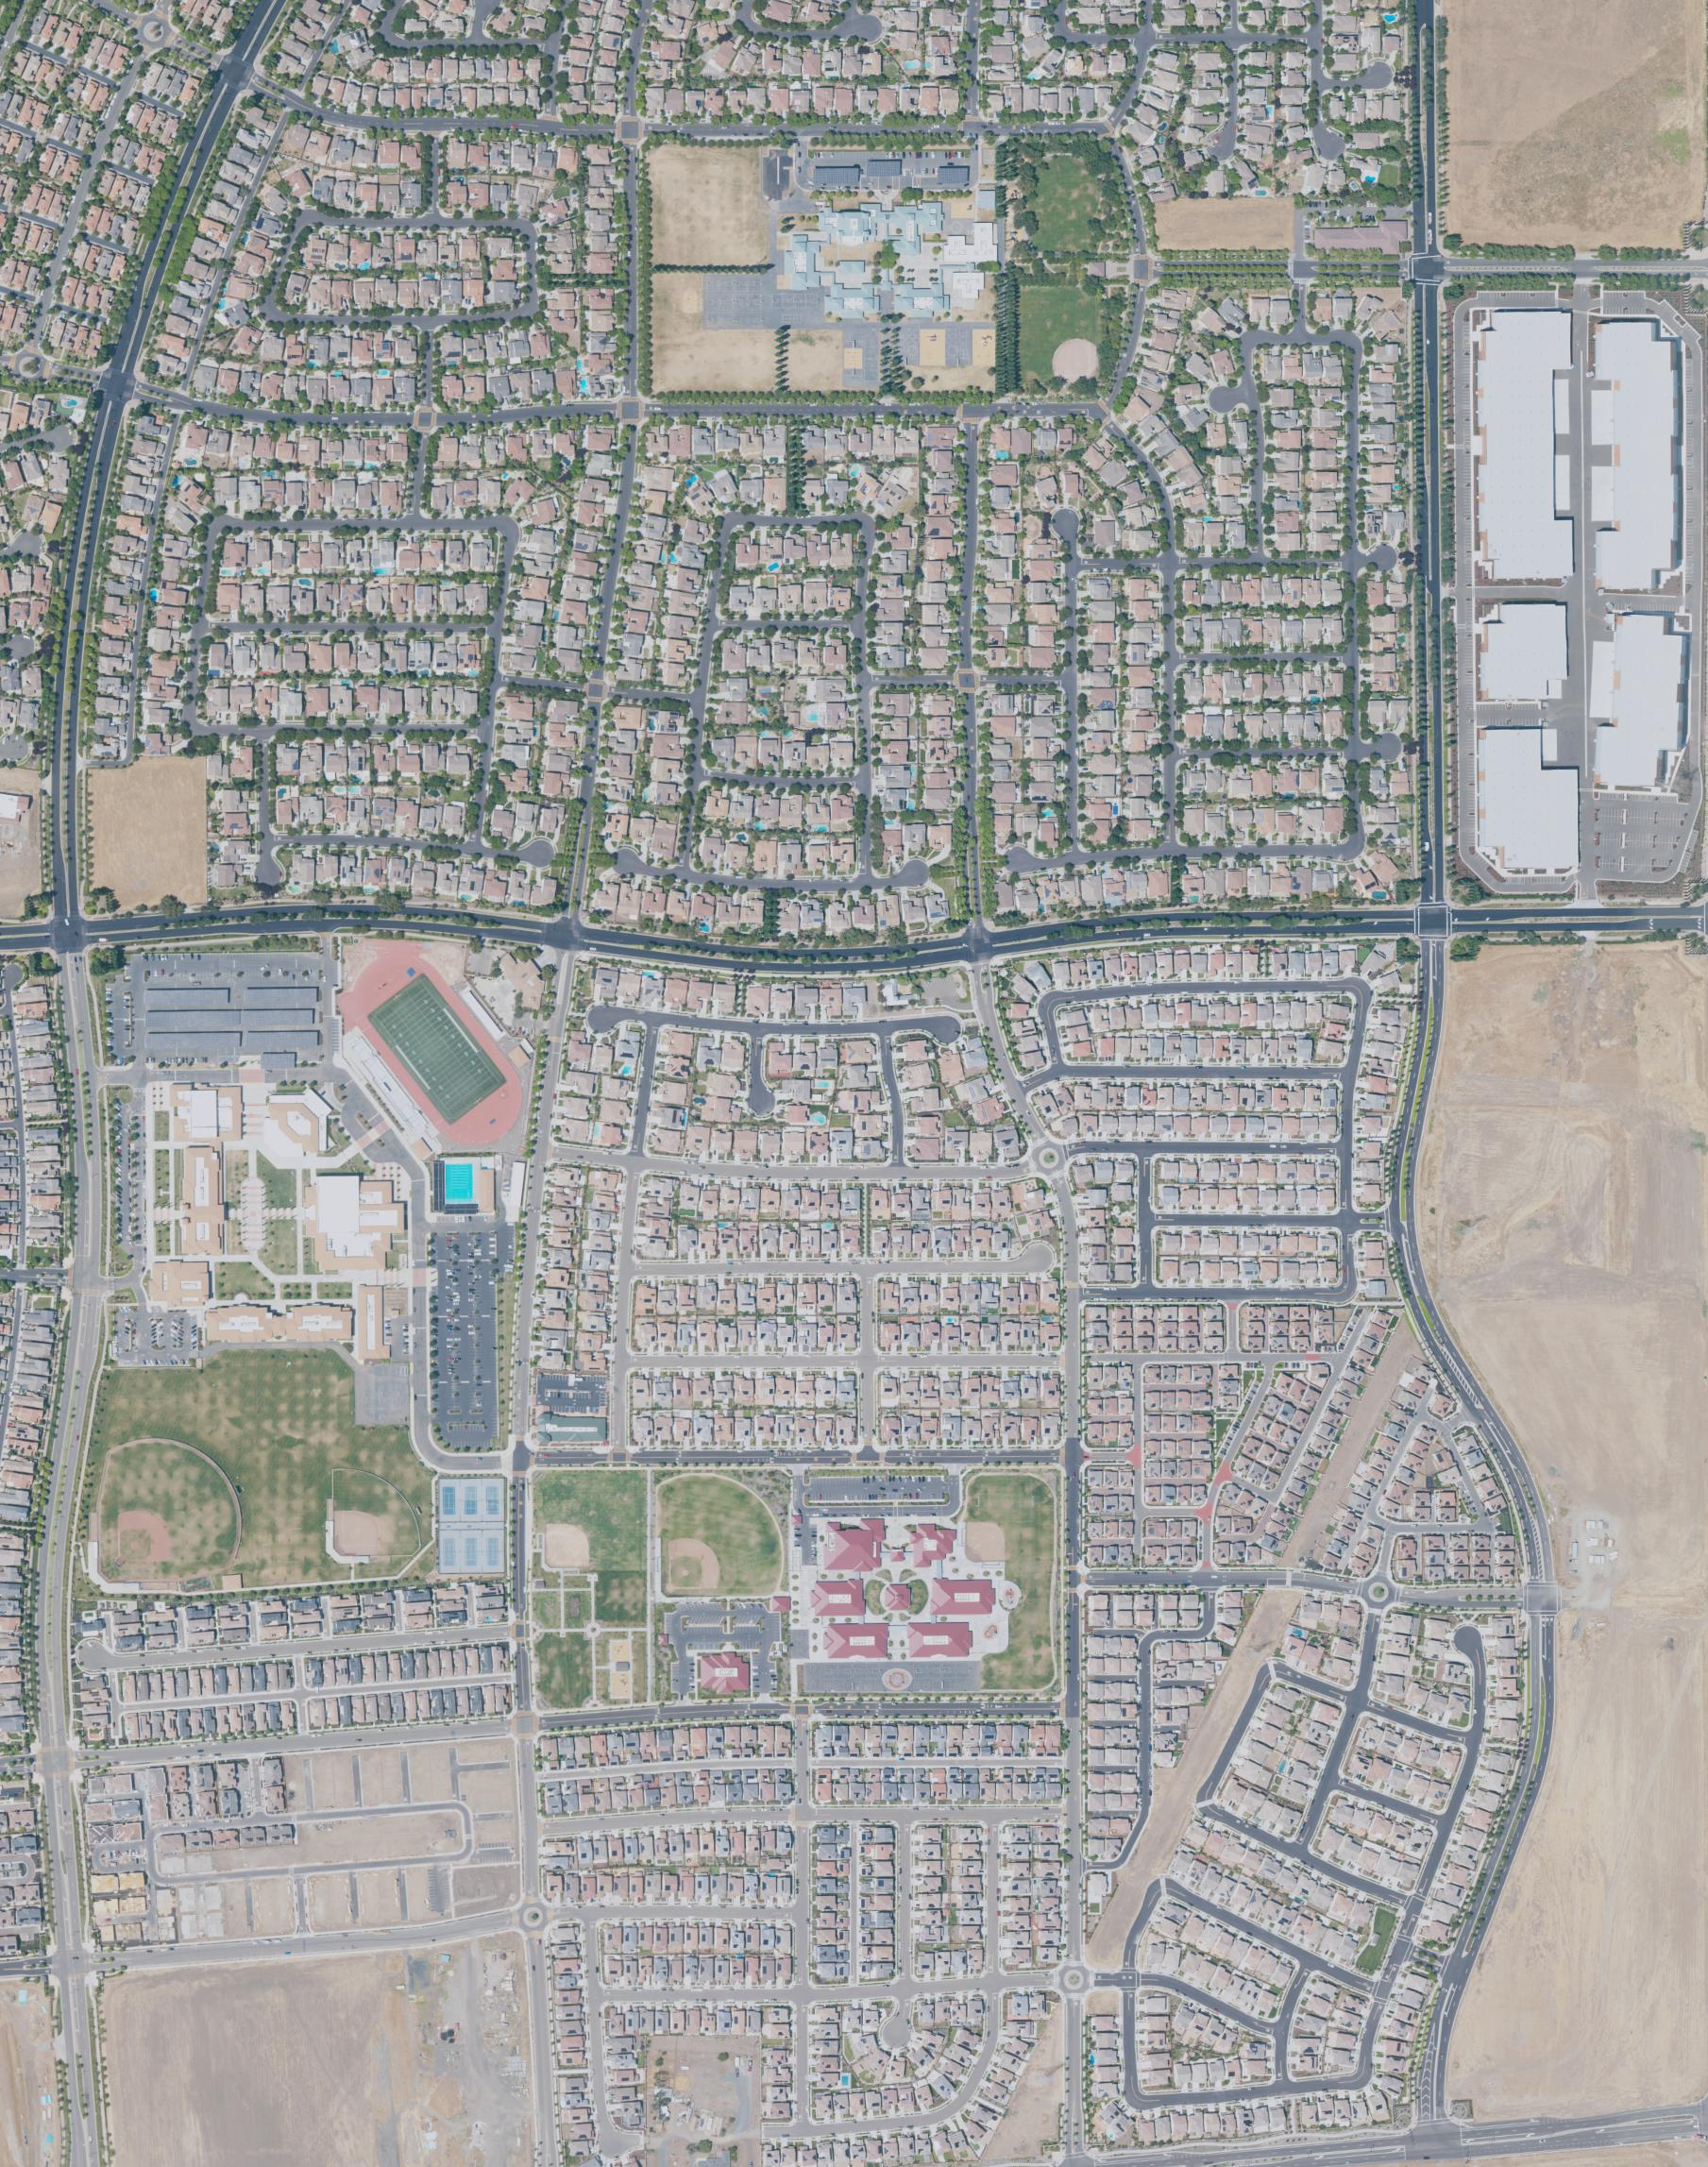

In [86]:
for year_and_date in years_and_dates:
    
    # unpack the year
    year = year_and_date['Year']
    
    # unpack the filter date
    filter_date = year_and_date['AcquisitionDate']
    
    # export the image
    export_image = naip_lyr.export_image(
        bbox = envelope,
        bbox_sr = 3857, 
        image_sr = 3857, 
        time = filter_date, # timestamp changed to iterating date
        rendering_rule = {'rasterFunction': "NaturalColor"}, 
        f = "image", 
        export_format='jpeg', 
        size = [w,h], 
        save_folder = r".", 
        save_file = rf"mountain_house_{year}.jpg", # file name changed to include year
        )
    
    print(year)
    display(Image(export_image))

Now that you've developed the script logic to export and view the imagery over Mountain House over time, you can visually see the development as the city expands.  In our next tutorial, we'll attempt to quantify that using imagery analysis.